In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Table of contents

1. Problem description
2. Environment preparation, data import
3. Data review
4. Data transformation
    - Bag of Words approach
    - TF-IDF approach
    - Word2Vec approach
5. Baseline modelling
6. Baseline result analysis
7. Dataset adjustment
8. Selecting the best model
    - Naive Bayes classifier
    - Logistic Regression classifier
    - LightGBM classifier
9. Best model result analysis
10. Retrieving sample unbalance problem
    - Undersampling
        - Naive random cut
        - NearMiss
    - Oversampling
        - SMOTE
        - ADASYN
11. Best model result analysis
12. Conclusion

# 1. Problem description

<b>Diagnostics prediction</b> is a project which aims to automatically predict diagnostics needed for a patient with certain anamnesis. 

The anamnesis is represented by a raw text file with doctor's notes about the patient, including his/her age, compaints described in free way, patient's history and so on. It is unstructured - different sections of oen patient anamnesis may abscent in another's.

The target labels are represented by the name of needed diagnostics procedure.

<b>The value</b> on the solution might be found in helping a doctor to find the optimal solution for diasnostics order. Patient can save time and money, and doctor can serve a patient more efficiently on sparing time for unnecessary diagnostics. Moreover, in difficult cases the algorithm may help a doctor to find a diagnosys faster, which in some cases may be extremely valuable, up to saving lives.

Theoretically some regularities found by the algorithm may help medical researchers to find the idea of treating some deseases, based on their unobvious interconnections with some symptoms.

# 2. Environment preparation, data import

In [2]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 24.9 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=b76f9d4e23e55449c8c980cae468f78be34f8942e0f12e7ee9b8afa3fdae7e4d
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [3]:
!pip uninstall tensorflow

Found existing installation: tensorflow 2.8.2+zzzcolab20220527125636
Uninstalling tensorflow-2.8.2+zzzcolab20220527125636:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.7/dist-packages/tensorflow-2.8.2+zzzcolab20220527125636.dist-info/*
    /usr/local/lib/python3.7/dist-packages/tensorflow/*
Proceed (y/n)? y
y
y
  Successfully uninstalled tensorflow-2.8.2+zzzcolab20220527125636


In [5]:
!pip install tensorflow===2.7.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 489.6 MB 25 kB/s 
     |████████████████████████████████| 1.3 MB 9.9 MB/s 
     |████████████████████████████████| 463 kB 57.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3


In [6]:
# Basic libraries

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
import random
import itertools
import keras.api._v2.keras as keras
from collections import defaultdict

# Preprocessing

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from itertools import combinations
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN

# Models

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegressionCV
import lightgbm as lgb

# Evaluation

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, make_scorer
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [127]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Sets/Corpus100_DM_pts_2844.csv')
print(data.shape)
data.head()

(2844, 11)


,PatientID,Age,Gender,VAN,Note,Examination,Test,Result,PC,ICD-10-CM,Diagnosed
0,62196,55,Female,180102cgf7,"T2 Diabetes25 years\n\nhumulin 70/30 20,20",Alk Phosphatase,Alkaline Phosphatase,100,"Loss apetite\nnausea,\nPolyurea\nloss of conci...",24.92,HORMONAL
1,62196,55,Female,180102cgf7,"T2 Diabetes25 years\n\nhumulin 70/30 20,20",Bicarbonate Serum,Bicarbonate Serum,20,"Loss apetite\nnausea,\nPolyurea\nloss of conci...",24.92,HORMONAL
2,62196,55,Female,180102cgf7,"T2 Diabetes25 years\n\nhumulin 70/30 20,20",BUN,BUN,27,"Loss apetite\nnausea,\nPolyurea\nloss of conci...",24.92,HORMONAL
3,62196,55,Female,180102cgf7,"T2 Diabetes25 years\n\nhumulin 70/30 20,20",BUN,Urea Serum,57.78,"Loss apetite\nnausea,\nPolyurea\nloss of conci...",24.92,HORMONAL
4,62196,55,Female,180102cgf7,"T2 Diabetes25 years\n\nhumulin 70/30 20,20",Calcium Serum,Calcium,12.3,"Loss apetite\nnausea,\nPolyurea\nloss of conci...",24.92,HORMONAL


The dataset contains of several categories, but we will need only <b>transcription</b>, which is the anamnesis, and <b>medical_specialty</b>, which is the target disgnostics type.

In [128]:
data = data[['Note','PC', 'Diagnosed']]#, 'Examination', 'Test', 'Result']]
data = data.drop(data[data['Note'].isna()].index)
data = data.drop(data[data['PC'].isna()].index)

# 3. Data review

Let's look at some item of the transcription

In [129]:
print(data.iloc[4]['Note'])
data.iloc[4]['PC']

T2 Diabetes25 years

humulin 70/30 20,20


'Loss apetite\nnausea,\nPolyurea\nloss of conciuos ness and dizziness'

We can see there are some constructions, which must be treated in order to clean the data.

Now look at the target distribution

In [130]:
data['Diagnosed'].value_counts()

DM                  2359
THYROID              248
HORMONAL             198
GROWTH                36
THYROID DISORDER       3
Name: Diagnosed, dtype: int64

Classes are deeply imbalanced. For 5000 objects it might be too much. We will check it later.

Let's check the sentence structure

In [131]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
#from keras.utils import to_categorical

# Create a list of tokens for each sentence
tokenizer = RegexpTokenizer(r'\w+')
data["Note tokens"] = data["Note"].apply(tokenizer.tokenize)
data["PC tokens"] = data["PC"].apply(tokenizer.tokenize)
#data["Exam tokens"] = data["Examination"].astype(str).apply(tokenizer.tokenize)
#data["Test tokens"] = data["Test"].astype(str).apply(tokenizer.tokenize)
#data["Result tokens"] = data["Result"].astype(str).apply(tokenizer.tokenize)
data['tokens'] = data["Note tokens"] + data["PC tokens"] #+ data["Exam tokens"] + data["Test tokens"] + data["Result tokens"]
all_words = [word for tokens in data["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in data["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

10114 words total, with a vocabulary size of 208
Max sentence length is 41


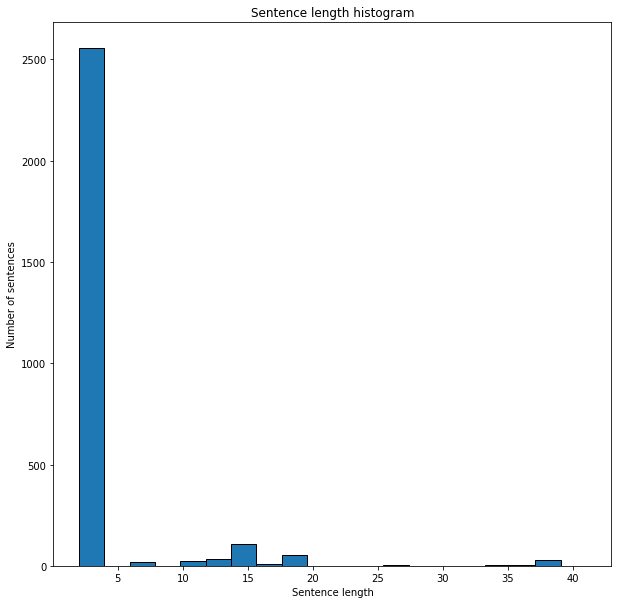

In [132]:
fig = plt.figure(figsize=(10, 10)) 
plt.title('Sentence length histogram')
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths, edgecolor = 'black', bins = 20)
plt.show()

In [133]:
print(f"Median sentence length {np.median(sentence_lengths)}")
print(f"Mean sentence length {round(np.mean(sentence_lengths), 2)}")

Median sentence length 2.0
Mean sentence length 3.56


Average sentence is long enough: median and mean values are over 400 words.

# 4. Data transformation

In [134]:
# Text preparation

def basic_preprocessing(df):
    
    df_temp = df.copy(deep = True)
    
    df_temp = df_temp.rename(index = str, columns = {'Note': 'Ntext','PC':'PCtext'})#, 'Examination': 'Etext',
                                                    # 'Test': 'Ttext', 'Result': 'Rtext'})
    
    df_temp.loc[:, 'Ntext'] = [text_prepare(x) for x in df_temp['Ntext'].values]
    df_temp.loc[:, 'PCtext'] = [text_prepare(x) for x in df_temp['PCtext'].values]
    #df_temp.loc[:, 'Etext'] = [text_prepare(x) for x in df_temp['Etext'].values]
    #df_temp.loc[:, 'Ttext'] = [text_prepare(x) for x in df_temp['Ttext'].values]
    #df_temp.loc[:, 'Rtext'] = [text_prepare(x) for x in df_temp['Rtext'].values]
    
    le = LabelEncoder()
    le.fit(df_temp['Diagnosed'])
    df_temp.loc[:, 'class_label'] = le.transform(df_temp['Diagnosed'])
    
    tokenizer = RegexpTokenizer(r'\w+')

    df_temp["Ntokens"] = df_temp["Ntext"].apply(tokenizer.tokenize)
    df_temp["PCtokens"] = df_temp["PCtext"].apply(tokenizer.tokenize)
    #df_temp["Etokens"] = df_temp["Etext"].apply(tokenizer.tokenize)
    #df_temp["Ttokens"] = df_temp["Ttext"].apply(tokenizer.tokenize)
    #df_temp["Rtokens"] = df_temp["Rtext"].apply(tokenizer.tokenize)
    
    return df_temp

def text_prepare(text):

    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
    BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
    STOPWORDS = set(stopwords.words('english'))
    
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub('', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    words = text.split()
    i = 0
    while i < len(words):
        if words[i] in STOPWORDS:
            words.pop(i)
        else:
            i += 1
    text = ' '.join(map(str, words))# delete stopwords from text
    
    return text

# Introduce evaluation metrics

def get_metrics(y_test, y_predicted):  

    precision = precision_score(y_test, y_predicted, average='weighted')             

    recall = recall_score(y_test, y_predicted, average='weighted')
    
    f1 = f1_score(y_test, y_predicted, average='weighted')
    
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

## 4.1. Bag of words

First we apply basic preprocessing function, which splits the words, removes unvaluable symbols and drop stopwords.

In [135]:

def BOW(data):
    
    df_temp = data.copy(deep = True)
    df_temp = basic_preprocessing(df_temp)

    count_vectorizer = CountVectorizer()
    count_vectorizer.fit(df_temp['Ntext'])
    count_vectorizer.fit(df_temp['PCtext'])
    #count_vectorizer.fit(df_temp['Etext'])
    #count_vectorizer.fit(df_temp['Ttext'])
    #count_vectorizer.fit(df_temp['Rtext'])

    list_corpus = df_temp['Ntext'].tolist() + df_temp['PCtext'].tolist() #+ df_temp['Etext'].tolist() + df_temp['Ttext'].tolist() + df_temp['Rtext'].tolist()
    list_labels = df_temp["class_label"].tolist() + df_temp["class_label"].tolist()
    
    X = count_vectorizer.transform(list_corpus)
    
    return X, list_labels

## 4.2. TF-IDF

For TD-IDF we use the same approach as before. The difference is that we use TF-IDF vectorizer instead of count vectorizer. We will check 1-grams only and mix of 1- and 2-grams.

In [136]:
def tfidf(data, ngrams = 1):

    df_temp = data.copy(deep = True)
    df_temp = basic_preprocessing(df_temp)
    
    tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, ngrams))
    tfidf_vectorizer.fit(df_temp['Ntext'])
    tfidf_vectorizer.fit(df_temp['PCtext'])
   # tfidf_vectorizer.fit(df_temp['Etext'])
   # tfidf_vectorizer.fit(df_temp['Ttext'])
   # tfidf_vectorizer.fit(df_temp['Rtext'])

    list_corpus = df_temp['Ntext'].tolist() + df_temp['PCtext'].tolist() #+ df_temp['Etext'].tolist() + df_temp['Ttext'].tolist() + df_temp['Rtext'].tolist()
    list_labels = df_temp["class_label"].tolist() + df_temp["class_label"].tolist()
    
    X = tfidf_vectorizer.transform(list_corpus)
    
    return X, list_labels

## 4.3. Word2Vec

For Word2Vec the approach is the same.

In [137]:
import gensim.downloader as api
word2vec = api.load('word2vec-google-news-300')#models.KeyedVectors.load_word2vec_format('https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [138]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [139]:
def w2v(data):
    
    df_temp = data.copy(deep = True)    
    df_temp = basic_preprocessing(df_temp)
    
    embeddings = get_word2vec_embeddings(word2vec, df_temp)
    list_labels = df_temp["class_label"].tolist()
    
    return embeddings, list_labels

# 5. Baseline modelling

As baseline model we'll choose LogisticRegression as one of the most verstily one. Calculating the score metrics for 4 ways described before: Bag of words, TF-IDF with 1-gram, TF-IDF with 2-gram, word2vec.

In [140]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [141]:
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state = 40)

clf = LogisticRegressionCV(cv = folds, solver = 'saga', 
                           multi_class = 'multinomial', n_jobs = -1, random_state = 40)

df_res = pd.DataFrame(columns = ['Preprocessing', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

# Bag of words approach
X, y = BOW(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
df_res = df_res.append({'Preprocessing': 'Bag of words',
                       'Precision': precision,
                       'Recall': recall,
                       'F1-score': f1,
                       'Accuracy': accuracy}, ignore_index = True)

# TF_IDF approach. 1-gram
X, y = tfidf(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
df_res = df_res.append({'Preprocessing': 'TF-IDF 1-gram',
                       'Precision': precision,
                       'Recall': recall,
                       'F1-score': f1,
                       'Accuracy': accuracy}, ignore_index = True)

# TF_IDF approach. 2-gram
X, y = tfidf(data, ngrams=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
df_res = df_res.append({'Preprocessing': 'TF-IDF 2-gram',
                       'Precision': precision,
                       'Recall': recall,
                       'F1-score': f1,
                       'Accuracy': accuracy}, ignore_index = True)

# Word2vec
X, y = w2v(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
df_res = df_res.append({'Preprocessing': 'Word2vec',
                       'Precision': precision,
                       'Recall': recall,
                       'F1-score': f1,
                       'Accuracy': accuracy}, ignore_index = True)

In [142]:
df_res

,Preprocessing,Precision,Recall,F1-score,Accuracy
0,Bag of words,0.85680,0.849736,0.791513,0.849736
1,TF-IDF 1-gram,0.85680,0.849736,0.791513,0.849736
2,TF-IDF 2-gram,0.85680,0.849736,0.791513,0.849736
3,Word2vec,0.89293,0.884007,0.849351,0.884007


# 6. Baseline result analysis

As we can see, quality metrics vary a lot. So we need to choose the one we will be targeting on.

- Accuracy is not a good choice as due to very unbalanced class maximizing it will force alorithm to predict the major one;
- Precision indicates how much we can trust the algorithm when it predicts a certain class;
- Recall shows how many of the true labels of the class are predicted correctly by the algorithm;
- F1-score is the harmonic mean of precision and recall.

As F1-score is the most balanced one of the metrics above, we will use it primarily, but still keeping an eye on others.

In [143]:
df_res

,Preprocessing,Precision,Recall,F1-score,Accuracy
0,Bag of words,0.85680,0.849736,0.791513,0.849736
1,TF-IDF 1-gram,0.85680,0.849736,0.791513,0.849736
2,TF-IDF 2-gram,0.85680,0.849736,0.791513,0.849736
3,Word2vec,0.89293,0.884007,0.849351,0.884007


The major classes are predicted quite well, but minor ones are confused a lot. Most possibly the reason is not only in unbalanceness of the classes, but in a very few absolute number of minor classes. Doubtfully the algorithm can gain some dependancies on 6 or 10 objects of one class.

So in order to make the model better we will get rid on the classes which are represented by less than 100 objects. For those we would need to get additional data.

# 7. Dataset adjustment

Dropping object with number of observations less than 100.

In [146]:
counts = data['Diagnosed'].value_counts()
data_100 = data[data['Diagnosed'].isin(counts[counts > 100].index)]

In [147]:
data_100['labels'] = LabelEncoder().fit_transform(data_100['Diagnosed'])

In [148]:
data_100['Diagnosed'].value_counts()

DM          2359
THYROID      248
HORMONAL     198
Name: Diagnosed, dtype: int64

Imbalance is still big, but this measure should help us get better results

# 8. Selecting the best model

Now having the baseline model on full dataset we will try to improve it using adjusted dataset and three of the most suitable algorithms: Naive Bayes, Logistic Regression and LightGBM.

## 8.1. Naive Bayes

In [149]:
def training_naive(X_train_naive, X_test_naive, y_train_naive, y_test_naive, preproc):
    
    clf = MultinomialNB()
    clf.fit(X_train_naive, y_train_naive)

    res = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])
    
    y_pred = clf.predict(X_test_naive)
    
    f1 = f1_score(y_pred, y_test_naive, average = 'weighted')
    pres = precision_score(y_pred, y_test_naive, average = 'weighted')
    rec = recall_score(y_pred, y_test_naive, average = 'weighted')
    acc = accuracy_score(y_pred, y_test_naive)
    
    res = res.append({'Preprocessing': preproc, 'Model': 'Naive Bayes', 'Precision': pres, 
                     'Recall': rec, 'F1-score': f1, 'Accuracy': acc}, ignore_index = True)

    return res

## 8.2. Logistic Regression

In [150]:
def training_logreg(X_train_log, X_test_log, y_train_log, y_test_log, preproc):
    
    folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 40)
    
    clf = LogisticRegressionCV(cv = folds, solver = 'saga', multi_class = 'multinomial', n_jobs = -1)
    
    clf.fit(X_train_log, y_train_log)

    res = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])
    
    y_pred = clf.predict(X_test_log)
    
    f1 = f1_score(y_pred, y_test_log, average = 'weighted')
    pres = precision_score(y_pred, y_test_log, average = 'weighted')
    rec = recall_score(y_pred, y_test_log, average = 'weighted')
    acc = accuracy_score(y_pred, y_test_log)
    
    res = res.append({'Preprocessing': preproc, 'Model': f'Logistic Regression', 'Precision': pres, 
                     'Recall': rec, 'F1-score': f1, 'Accuracy': acc}, ignore_index = True)

    return res

## 8.3. LightGBM

For LightGBM first we need make a pretune for the model to perform close to well

In [151]:
def training_lgbm(X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm, preproc,
                 n = 120, depth = 4, child = 2, bag = 0.9, feature = 0.9, l1 = 1, l = 0.01, w2v = False):
    
    if w2v:
        d_train = lgb.Dataset(X_train_lgbm, label=y_train_lgbm)
    else:
        d_train = lgb.Dataset(X_train_lgbm.astype(np.float32), label=y_train_lgbm)

    early_stop = 500
    verbose_eval = False
    num_rounds = n

    params = {
        'objective': 'multiclass',
        'num_class': len(set(y_train_lgbm)),
        'boosting': 'gbdt', 
        'metric': 'multi_logloss',
        'max_depth': depth, 
        'max_bin': 22, 
        'bagging_fraction': bag, 
        'feature_fraction': feature, 
        'min_child_samples': child, 
        'min_child_weight': 1, 
        'learning_rate': l,
        'verbosity': -1, 
        'data_random_seed': 17,
        'lambda_l1': l1}

    model = lgb.train(params, train_set = d_train, num_boost_round = num_rounds)

    y_pred_proba = model.predict(X_test_lgbm.astype(np.float32), num_iteration=model.best_iteration)
    y_pred = [np.argmax(x) for x in y_pred_proba]
    
    res = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])
        
    f1 = f1_score(y_pred, y_test_lgbm, average = 'weighted')
    pres = precision_score(y_pred, y_test_lgbm, average = 'weighted')
    rec = recall_score(y_pred, y_test_lgbm, average = 'weighted')
    acc = accuracy_score(y_pred, y_test_lgbm)
    
    res = res.append({'Preprocessing': preproc, 'Model': 'LightGBM', 'Precision': pres, 
                     'Recall': rec, 'F1-score': f1, 'Accuracy': acc}, ignore_index = True)

    return res

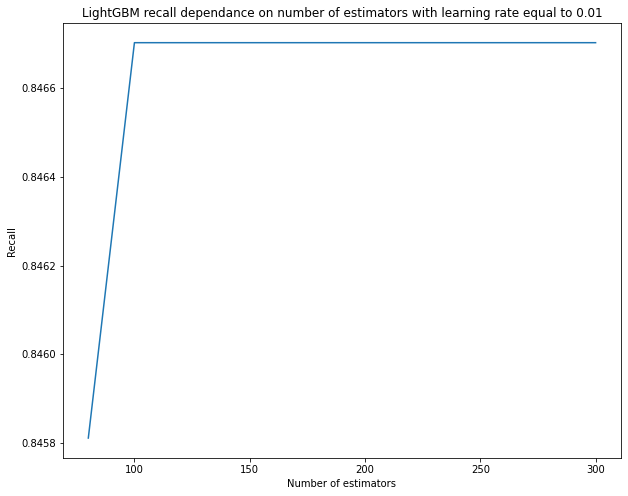

In [152]:
# Tune number of estimator at learning rate = 0.01

X, y = BOW(data_100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
ns = range(80, 301, 20)
recalls = []
for n in ns:
    recalls.append(training_lgbm(X_train, X_test, y_train, y_test, 'Count', n = n, l = 0.01)['Recall'].values[0])
fig = plt.figure(figsize = (10, 8))
plt.plot(ns, recalls, label = 'Recall')
plt.xlabel('Number of estimators')
plt.ylabel('Recall')
plt.title('LightGBM recall dependance on number of estimators with learning rate equal to 0.01')
plt.show()

In [153]:
# Tune maximum tree depth and minimum elements in leaf

depths = range(2, 7, 2)
childs = range(2, 7, 2)
recalls = []
for depth in depths:
    for child in childs:
        recalls.append([training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-gram', 
                                     n = 120, l = 0.01, depth = depth, child = child)['Recall'].values[0], depth, child])
recalls.sort(reverse = True)
recalls[:3]

[[0.8467023172905526, 6, 6],
 [0.8467023172905526, 6, 4],
 [0.8467023172905526, 6, 2]]

Optimal parameters for preliminary tuning are:
 - number of estimators = 120
 - learning rate = 0.01
 - maximum tree depth = 4
 - minimum samples in leaf = 2

## 8.4. Calculations

In [154]:
# DataFrame for result evaluation

full_result = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

# Testing Count Vectorizer

X, y = BOW(data_100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
full_result = full_result.append(training_naive(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
full_result = full_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
full_result = full_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)

# Testing TF-IDF with 1-gram

X, y = tfidf(data_100, ngrams = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
full_result = full_result.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
full_result = full_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
full_result = full_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)

# Testing TF-IDF with 2-gram

X, y = tfidf(data_100, ngrams = 2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
full_result = full_result.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)
full_result = full_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)
full_result = full_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 2-grams'), ignore_index = True)

# Testing Word2vec

X, y = w2v(data_100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
full_result = full_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec'), ignore_index = True)

full_result

,Preprocessing,Model,Precision,Recall,F1-score,Accuracy
0,Count Vectorize,Naive Bayes,0.975914,0.848485,0.899264,0.848485
1,Count Vectorize,Logistic Regression,0.978921,0.851159,0.901611,0.851159
2,Count Vectorize,LightGBM,0.982109,0.846702,0.901435,0.846702
3,TF-IDF 1-grams,Naive Bayes,0.975299,0.849376,0.899310,0.849376
4,TF-IDF 1-grams,Logistic Regression,0.978921,0.851159,0.901611,0.851159
5,TF-IDF 1-grams,LightGBM,0.982109,0.846702,0.901435,0.846702
6,TF-IDF 2-grams,Naive Bayes,0.975299,0.849376,0.899310,0.849376
7,TF-IDF 2-grams,Logistic Regression,0.978921,0.851159,0.901611,0.851159
8,TF-IDF 2-grams,LightGBM,0.982109,0.846702,0.901435,0.846702
9,Word2vec,Logistic Regression,0.974089,0.887701,0.921555,0.887701


For basic setup all data preprocessing approaches work closely well. The the combination of the exact algorithm and preprocessing method make the difference. F1-score is the highest for Naive Bayes for 1-gram TF-IDF approach. But mostly the advantage is in high precision score. Recall is relatively low. The overall best approach seems to be Word2vec with LogisticRegression.

We will confirm or reject this hypothesis in later calculations.

# 9. Best model result analysis


The scores became remarkably higher. Let us take a look on confusion matrix for the best model

In [155]:
# Re-setup the algorithm

X, y = w2v(data_100)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y, test_size=0.2, random_state=40)
folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 40)
clf_w2v = LogisticRegressionCV(cv = folds, solver = 'saga', multi_class = 'multinomial', n_jobs = -1)
clf_w2v.fit(X_train_log, y_train_log)
y_pred = clf_w2v.predict(X_test_log)

In [156]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=40)
    cb = plt.colorbar()
    for t in cb.ax.get_yticklabels():
      t.set_fontsize(20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20, rotation = 90)
    plt.yticks(tick_marks, classes, fontsize=20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=20)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

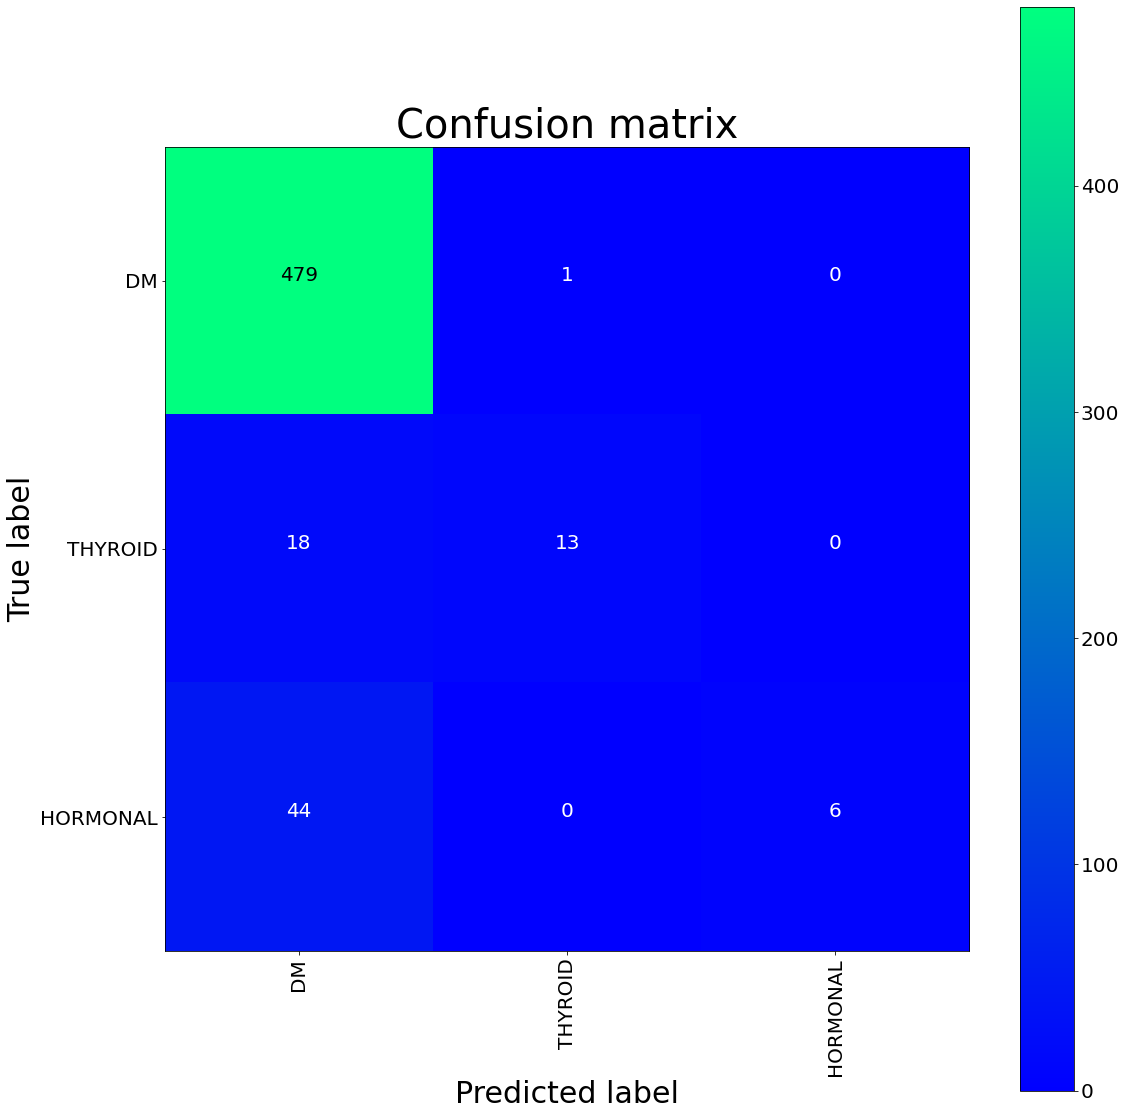

In [157]:
classes = ['DM', 'THYROID','HORMONAL']
#classes = ['DM','TIA','Follow up case of Parathyroidectomy','NO OBVIOUS CV CAUSE IDENTIFIED',
#'CA BREAST','DYSPNEA','HTN','SINUS TACHYCARDIA ? CAUSE','HORMONAL','THYROID','HYPOTHYROIDISM',
#'MINIMAL CAD','INCREDIBLE STUDY','Hyper lipidemia','F/Up Thyroidectomy and Parathyroidectomy',
#'Paresthesias','Sleep Starter (Jerk)','CV ASSESSMENT']
#classes = ['DM','THYROID','Stroke','HORMONAL','COPD','Steroid Induced Diabetes',
#           'PNEUMONIA','SUBCLINICAL HYPOTHYROIDISM','Obesity','Gestational Diabetes',
#           'Primary Hyperparathyrodism','Sheehan Syndrome',
#           'Pituitary Macroadenoma Treated with Transphenoidal surgery',
#           'Toxic Epidermal Necrolysis secondary to Meloxicam','OSTEOARTHIRITIS',
#           'Postural Drop','Parkinson Disease Plus','Thyroiditis','Hypoglycaemia',
#           'ANEMIA','Amiodarone associated Hyperthyroidism (Type 1)','KIDNEY INFECTION',
#           'Vitamin D Deficiency','LUNGS INFECTIONS','Prediabetes','Urinary Tract Infection']
cm = confusion_matrix(y_test_log, y_pred)
fig = plt.figure(figsize=(16, 16))

plot = plot_confusion_matrix(cm, classes=classes, normalize=False, 
                             title='Confusion matrix')
#plt.show()
plt.savefig("cf2.png")
from google.colab import files
files.download("cf2.png")

Another way to see how the model works is to manually watch at the most valuable and the least valuable words for the class.

In [158]:
vector_store = word2vec
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(CountVectorizer(), clf)

random.seed(40)

data_100_prep = basic_preprocessing(data_100)
list_corpus = data_100_prep['Ntext'].tolist() + data_100_prep['PCtext'].tolist()
list_labels = data_100_prep["class_label"].tolist() + data_100_prep["class_label"].tolist()
    
X_train_data, X_test_data, y_train_data, y_test_data = train_test_split(list_corpus, list_labels, test_size=0.2, 
                                                                                random_state=40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()
    
    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)
    
    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)
        
        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]    
    
    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
            'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'DM',
    1: 'THYROID',
    2: 'HORMONAL'
    
#label_to_text = {
#    0: 'DM',
#    1: 'TIA',
#    2: 'Follow up case of Parathyroidectomy',
#    3: 'NO OBVIOUS CV CAUSE IDENTIFIED',
#    4: 'CA BREAST',
#    5: 'DYSPNEA',
#    6: 'HTN',
#    7: 'SINUS TACHYCARDIA ? CAUSE',
#    8: 'HORMONAL',
#    9: 'THYROID',
#    10: 'HYPOTHYROIDISM',
#    11: 'MINIMAL CAD',
#    12: 'INCREDIBLE STUDY',
#    13: 'Hyper lipidemia',
#    14: 'F/Up Thyroidectomy and Parathyroidectomy',
#    15: 'Paresthesias',
#    16: 'Sleep Starter (Jerk)',
#    17: 'CV ASSESSMENT'

#label_to_text = {
#    0: 'DM', 
#    1: 'THYROID', 
#    2: 'Stroke',
#    3: 'HORMONAL', 
#    4: 'COPD',             
#    5: 'Steroid Induced Diabetes',        
#    6: 'PNEUMONIA',            
#    7: 'SUBCLINICAL HYPOTHYROIDISM',
#    8: 'Obesity', 
#    9: 'Gestational Diabetes',            
#    10: 'Primary Hyperparathyrodism',            
#    11: 'Sheehan Syndrome',                 
#    12: 'Pituitary Macroadenoma Treated with Transphenoidal surgery',
#    13: 'Toxic Epidermal Necrolysis secondary to Meloxicam',
#    14: 'OSTEOARTHIRITIS',                           
#    15: 'Postural Drop',
#    16: 'Parkinson Disease Plus',
#    17: 'Thyroiditis',
#    18: 'Hypoglycaemia',
#    19: 'ANEMIA',
#    20: 'Amiodarone associated Hyperthyroidism (Type 1)',
#    21: 'KIDNEY INFECTION',
#    22: 'Vitamin D Deficiency',
#    23: 'LUNGS INFECTIONS',
#    24: 'Prediabetes',
#    25: 'Urinary Tract Infection'
}
sorted_contributions = get_statistical_explanation(X_test_data, 100, word2vec_pipeline, label_to_text)

In [159]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=14)
    plt.yticks(y_pos, bottom_words, fontsize=10)
    plt.suptitle('Key words', fontsize=12)
    plt.xlabel('Importance', fontsize=12)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title("Relevant for " + name, fontsize=14)
    plt.yticks(y_pos, top_words, fontsize=12)
    plt.suptitle(f"Most important words for {name}", fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

test_label = 'Hypoglycaemia'
top_words = sorted_contributions[test_label]['supporters'][:5].index.tolist()
top_scores = sorted_contributions[test_label]['supporters'][:5].tolist()
bottom_words = sorted_contributions[test_label]['detractors'][:5].index.tolist()
bottom_scores = sorted_contributions[test_label]['detractors'][:5].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, test_label)

KeyError: ignored

In [ ]:
test_label = 'ANEMIA'
top_words = sorted_contributions[test_label]['supporters'][:5].index.tolist()
top_scores = sorted_contributions[test_label]['supporters'][:5].tolist()
bottom_words = sorted_contributions[test_label]['detractors'][:5].index.tolist()
bottom_scores = sorted_contributions[test_label]['detractors'][:5].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, test_label)

In [ ]:
test_label = 'KIDNEY INFECTION'
top_words = sorted_contributions[test_label]['supporters'][:5].index.tolist()
top_scores = sorted_contributions[test_label]['supporters'][:5].tolist()
bottom_words = sorted_contributions[test_label]['detractors'][:5].index.tolist()
bottom_scores = sorted_contributions[test_label]['detractors'][:5].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, test_label)

The words influence on relevancy seems to be truthful. Which can mean that we are going in the right direction.

Let us continue with fixing the class imbalance.

# 10. Retrieving sample unbalance problem

We can see that classes imbalance still prevents us from getting a better result.

There are several ways to fight imbalance:

1. Undersampling
2. Oversampling
3. Use classifiers with class-weight adjustments

The last one we already did with logistic regression.

Undersampling is cutting off some observations of the major classes to make them more comparable in count with the minor ones. Due to the amount of data we have, such approach might not be profitable, as we make the amount of data even smaller, which might affect model quality. But still we can try.
Simple random drop of some observations share based on the assumption that dropping some samples will not affect he distribution. Randomness of the samples pick and small amount of data doesn't ensure it. So we need to apply more complex methods.

Oversampling, counterwise to undersampling, is adding more copies of observations from minor classes to straighted classes distribution. As we are working with text data, doubling some samples will probably lead to overfitting on these samples. So, just like in the case of undersampling we will need more complex approach.

## 10.1. Undersampling. Naive approach

First we check how many observation the undersampling algorithm cuts off

In [160]:
naive_under_sample = RandomUnderSampler(sampling_strategy = 'majority')
X, y = BOW(data_100)
print(f"Initial set observations {X.shape[0]}")
print(f"Initial set target classes {len(set(y))}")
X, y = naive_under_sample.fit_resample(X, y)
print(f"Modified set observations {X.shape[0]}")
print(f"Modified set target classes {len(set(y))}")

Initial set observations 5610
Initial set target classes 3
Modified set observations 1288
Modified set target classes 3


In [161]:
# DataFrame for result evaluation

naive_result = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

naive_under_sample = RandomUnderSampler(sampling_strategy = 'majority')

# Testing Count Vectorizer

X, y = BOW(data_100)
X, y = naive_under_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
naive_result = naive_result.append(training_naive(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
naive_result = naive_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
naive_result = naive_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)

# Testing TF-IDF with 1-gram

X, y = tfidf(data_100, ngrams = 1)
X, y = naive_under_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
naive_result = naive_result.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
naive_result = naive_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
naive_result = naive_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)

# Testing Word2vec

X, y = w2v(data_100)
X, y = naive_under_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
naive_result = naive_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec'), ignore_index = True)

In [162]:
naive_result

,Preprocessing,Model,Precision,Recall,F1-score,Accuracy
0,Count Vectorize,Naive Bayes,0.951244,0.445736,0.563661,0.445736
1,Count Vectorize,Logistic Regression,0.916806,0.488372,0.587488,0.488372
2,Count Vectorize,LightGBM,0.916806,0.488372,0.587488,0.488372
3,TF-IDF 1-grams,Naive Bayes,0.958368,0.437984,0.563800,0.437984
4,TF-IDF 1-grams,Logistic Regression,0.919608,0.488372,0.586978,0.488372
5,TF-IDF 1-grams,LightGBM,0.919608,0.488372,0.586978,0.488372
6,Word2vec,Logistic Regression,0.891791,0.550388,0.609563,0.550388


One can see, that naive approach didn't make any significant gain in metrics. Recall became better in overall, but precision dropped. F1-score therefore slightly decreased.

As an alternative we will try NearMiss method.

## 10.2. Undersampling. NearMiss

How many observation the undersampling algorithm cuts off.

In [163]:
near_under_sample = NearMiss(sampling_strategy='majority')
X, y = BOW(data_100)
print(f"Initial set observations {X.shape[0]}")
print(f"Initial set target classes {len(set(y))}")
X, y = near_under_sample.fit_resample(X, y)
print(f"Modified set observations {X.shape[0]}")
print(f"Modified set target classes {len(set(y))}")

Initial set observations 5610
Initial set target classes 3
Modified set observations 1288
Modified set target classes 3


In [164]:
# DataFrame for result evaluation

near_result = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

near_under_sample = NearMiss(sampling_strategy='majority')

# Testing Count Vectorizer

X, y = BOW(data_100)
X, y = near_under_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
near_result = near_result.append(training_naive(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
near_result = near_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
near_result = near_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)

# Testing TF-IDF with 1-gram

X, y = tfidf(data_100, ngrams = 1)
X, y = near_under_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
near_result = near_result.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
near_result = near_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
near_result = near_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)

# Testing Word2vec

X, y = w2v(data_100)
X, y = near_under_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
near_result = near_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec'), ignore_index = True)

In [165]:
near_result

,Preprocessing,Model,Precision,Recall,F1-score,Accuracy
0,Count Vectorize,Naive Bayes,0.965910,0.430233,0.564698,0.430233
1,Count Vectorize,Logistic Regression,0.869744,0.519380,0.596988,0.519380
2,Count Vectorize,LightGBM,0.870472,0.511628,0.596247,0.511628
3,TF-IDF 1-grams,Naive Bayes,0.965910,0.430233,0.564698,0.430233
4,TF-IDF 1-grams,Logistic Regression,0.869744,0.519380,0.596988,0.519380
5,TF-IDF 1-grams,LightGBM,0.870472,0.511628,0.596247,0.511628
6,Word2vec,Logistic Regression,0.925581,0.511628,0.608279,0.511628


NearMiss method gave almost the same result as naive approach. Which may treat like naive random undersampling have basically preserved the orginal distribution.

## 10.3. Oversampling. SMOTE

For oversampling algorithm check how many observation the algorithm generates.

In [166]:
smote_over_sample = SMOTE(sampling_strategy='minority')
X, y = BOW(data_100)
print(f"Initial set observations {X.shape[0]}")
print(f"Initial set target classes {len(set(y))}")
X, y = smote_over_sample.fit_resample(X, y)
print(f"Modified set observations {X.shape[0]}")
print(f"Modified set target classes {len(set(y))}")

Initial set observations 5610
Initial set target classes 3
Modified set observations 9932
Modified set target classes 3


In [167]:
# DataFrame for result evaluation

smote_result = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

smote_over_sample = SMOTE(sampling_strategy='minority')

# Testing Count Vectorizer

X, y = BOW(data_100)
X, y = smote_over_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
smote_result = smote_result.append(training_naive(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
smote_result = smote_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
smote_result = smote_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)

# Testing TF-IDF with 1-gram

X, y = tfidf(data_100, ngrams = 1)
X, y = smote_over_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
smote_result = smote_result.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
smote_result = smote_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
smote_result = smote_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)

# Testing Word2vec

X, y = w2v(data_100)
X, y = smote_over_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
smote_result = smote_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec'), ignore_index = True)

In [168]:
smote_result

,Preprocessing,Model,Precision,Recall,F1-score,Accuracy
0,Count Vectorize,Naive Bayes,0.926154,0.537494,0.631778,0.537494
1,Count Vectorize,Logistic Regression,0.871931,0.618017,0.666970,0.618017
2,Count Vectorize,LightGBM,0.863236,0.614997,0.666343,0.614997
3,TF-IDF 1-grams,Naive Bayes,0.921095,0.549069,0.636022,0.549069
4,TF-IDF 1-grams,Logistic Regression,0.872293,0.612481,0.662832,0.612481
5,TF-IDF 1-grams,LightGBM,0.865887,0.605435,0.660190,0.605435
6,Word2vec,Logistic Regression,0.882653,0.627767,0.672755,0.627767


SMOTE generated oversampling procedure gave a huge leap in quality. More importantly - the quality have got gain in every direction, including both precision and recall.

## 10.4. Oversampling. ADASYN

For oversampling algorithm check how many observation the algorithm generates.

In [169]:
adasyn_over_sample = ADASYN(sampling_strategy='minority')
X, y = BOW(data_100)
print(f"Initial set observations {X.shape[0]}")
print(f"Initial set target classes {len(set(y))}")
X, y = adasyn_over_sample.fit_resample(X, y)
print(f"Modified set observations {X.shape[0]}")
print(f"Modified set target classes {len(set(y))}")

Initial set observations 5610
Initial set target classes 3
Modified set observations 9955
Modified set target classes 3


In [170]:
# DataFrame for result evaluation

adasyn_result = pd.DataFrame(columns = ['Preprocessing', 'Model', 'Precision', 'Recall', 'F1-score', 'Accuracy'])

adasyn_over_sample = ADASYN(sampling_strategy='minority')

# Testing Count Vectorizer

X, y = BOW(data_100)
X, y = adasyn_over_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
adasyn_result = adasyn_result.append(training_naive(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
adasyn_result = adasyn_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)
adasyn_result = adasyn_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'Count Vectorize'), ignore_index = True)

# Testing TF-IDF with 1-gram

X, y = tfidf(data_100, ngrams = 1)
X, y = adasyn_over_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
adasyn_result = adasyn_result.append(training_naive(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
adasyn_result = adasyn_result.append(training_logreg(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)
adasyn_result = adasyn_result.append(training_lgbm(X_train, X_test, y_train, y_test, 'TF-IDF 1-grams'), ignore_index = True)

# Testing Word2vec

X, y = w2v(data_100)
X, y = adasyn_over_sample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
adasyn_result = adasyn_result.append(training_logreg(X_train, X_test, y_train, y_test, 'Word2vec'), ignore_index = True)

In [171]:
adasyn_result

,Preprocessing,Model,Precision,Recall,F1-score,Accuracy
0,Count Vectorize,Naive Bayes,0.703892,0.426921,0.516700,0.426921
1,Count Vectorize,Logistic Regression,0.888864,0.556002,0.627976,0.556002
2,Count Vectorize,LightGBM,0.888799,0.554495,0.628931,0.554495
3,TF-IDF 1-grams,Naive Bayes,0.719037,0.423482,0.521329,0.423482
4,TF-IDF 1-grams,Logistic Regression,0.889115,0.560462,0.631733,0.560462
5,TF-IDF 1-grams,LightGBM,0.889420,0.558455,0.632035,0.558455
6,Word2vec,Logistic Regression,0.964105,0.530531,0.656147,0.530531


ADASYN algorithm have shown approximately the same results as SMOTE. But still it's slightly worse. So we will keep to SMOTE.

# 11. Best model result analysis

Best model of all we have received is word2vec on SMOTE trained on Logistic Regression.

Let's look at its confusion matrix.

In [172]:
X, y = w2v(data_100)
X, y = smote_over_sample.fit_resample(X, y)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(X, y, test_size=0.2, random_state=40)
clf_w2v_smote = LogisticRegressionCV(cv = folds, solver = 'saga', multi_class = 'multinomial', n_jobs = -1)
clf_w2v_smote.fit(X_train_smote, y_train_smote)
y_pred = clf_w2v_smote.predict(X_test_smote)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

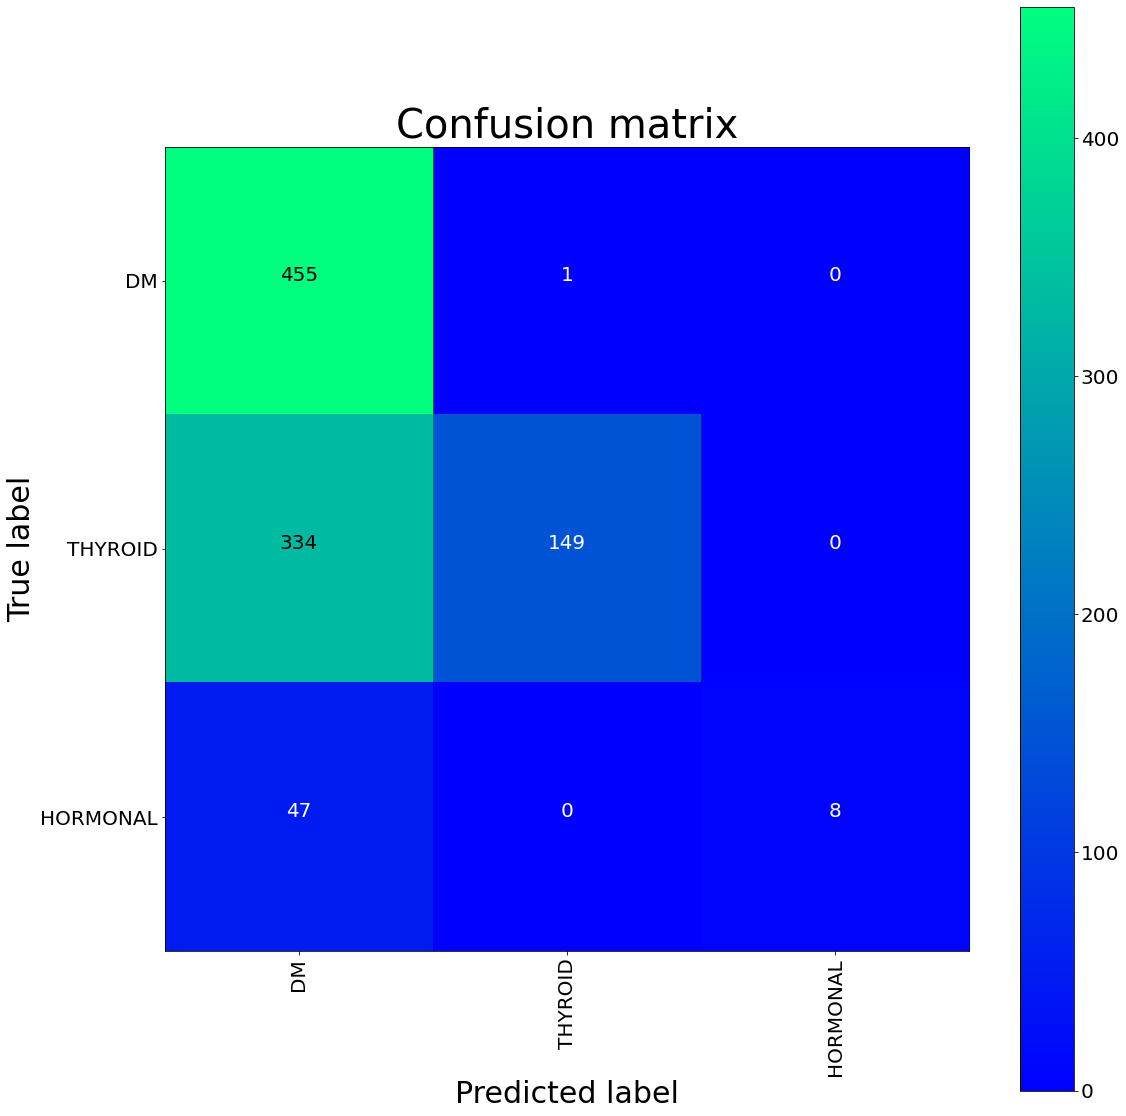

In [173]:
cm = confusion_matrix(y_test_smote, y_pred)
fig = plt.figure(figsize=(16, 16))
plot = plot_confusion_matrix(cm, classes=classes, normalize=False, 
                             title='Confusion matrix')
#plt.show()
from google.colab import files
plt.savefig("cf_smote1.png")
files.download("cf_smote1.png")

Result metrics for each class

In [ ]:
final_metrics = pd.DataFrame({'Labels': range(26), 
                              'Recall': recall_score(y_pred, y_test_smote, average = 'weighted'),
                             'Precision': precision_score(y_pred, y_test_smote, average = 'weighted'),
                             'F1-score': f1_score(y_pred, y_test_smote, average = 'weighted')})
final_metrics['Labels'] = final_metrics['Labels'].replace(label_to_text)
final_metrics

,Labels,Recall,Precision,F1-score
0,DM,1.0,1.0,1.0
1,THYROID,1.0,1.0,1.0
2,Stroke,1.0,1.0,1.0
3,HORMONAL,1.0,1.0,1.0
4,COPD,1.0,1.0,1.0
5,Steroid Induced Diabetes,1.0,1.0,1.0
6,PNEUMONIA,1.0,1.0,1.0
7,SUBCLINICAL HYPOTHYROIDISM,1.0,1.0,1.0
8,Obesity,1.0,1.0,1.0
9,Gestational Diabetes,1.0,1.0,1.0


The result is still not perfect, but yet it is much better, than it was in the beginning. Some classes are recognized pretty well.

# 12. Conclusion

In this work I made an attempt to build an algorithm, which would predict necessary diagnostics for a patient based on his anamnesis. From basic f1-score of around 0.3 I managed to increase capability of the algorithm up to nearly 0.7.

I barely can be used in real-life diagnostics. but still could be helpful in some adjuscent fields. These could be analysing some popular words-triggers for different diseases in scientific or applied purpose, optimisation of medical facility schedule or a way of preliminary patient analysis in order to desrease a list of potential diagnostics.

This work can be proceeded with more detailed text analysis.

- Anamnesis text contains some kind of headers for allergies or previous treatment. It may be profitable to try to use it in modelling;
- More detailed analysis of metrics could be used in order to understand better the specifics of how algorithm works with different classes;
- Wider range of algorithms could be tried in order to find the best one;
- For existing algorithms a more precise tuning could have given some more fractions of a percent;
- Some additional information on minor classes could be used to include them into calculation.

Some of these ideas I will use to improve the quality of the algorithm. But this would be outside the limits of current work.